# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [2]:
import time
import numpy as np
import tensorflow as tf

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

# tqdm を 継承したクラスを作成
# インスタンス作成は、tqdmの引数が使える
# hookという関数を作成している
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [4]:
# zipファイルが無かったらダウンロードする

# ファイル名の指定
dataset_filename    = 'text8.zip'
dataset_name        = 'Text8 Dataset'
dataset_file_URL    = 'http://mattmahoney.net/dc/text8.zip'

# ダウンロード
if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(dataset_file_URL, dataset_filename, pbar.hook )

In [5]:
# zipファイルを解凍する        

# フォルダ名の指定
dataset_folder_path = 'data'        

# 解凍
if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)

In [6]:
# テキストファイルの読み込み        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [7]:
from collections import Counter

# 句読点(punctuation)を単語として扱えるように、文字列・置換する
# 出現頻度が小さい単語を削除する
def preprocess(text, thresh_word_occurence=5):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    # Counter : リストの各要素の出現個数をカウント
    #  -> 辞書に似ていて、単語を入力すると、カウント数が返ってくる
    word_counts   = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > thresh_word_occurence]

    return trimmed_words

In [8]:
# 自作関数を用いて、文字列を分割して、Listを作成する
# ソートはしていない
words        = preprocess(text)

# setを用いて、重複を削除した List を作成する
unique_words = list( set(words) )

### 中身のチェック

In [9]:
print("type(words)        = ", type(words))
print(" ")
print("type(unique_words) = ", type(unique_words))
print(" ")
print("words[:10] = \n", words[:10])
print(" ")
print("unique_words[:10] = \n", unique_words[:10])

type(words)        =  <class 'list'>
 
type(unique_words) =  <class 'list'>
 
words[:10] = 
 ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
 
unique_words[:10] = 
 ['misdirection', 'rivaling', 'mohel', 'fenice', 'infective', 'handlebars', 'neill', 'bimba', 'improvement', 'flank']


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [10]:
# ID <=> 文字　の変換辞書を作成
# ID は、小さいほうが、出現数が多い
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    # Counter : リストの各要素の出現個数をカウント、降順にリストされる
    word_counts = Counter(words)
    
    # Counter要素の文字列のみを取得して List を作成したい
    # reverse=Trueで降順にする
    # word_counts.get("the") -> 1061396　となるので、数値を get して sort している
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    
    # ID <=> 文字　の変換辞書を作成
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [11]:
# 自作関数を利用して、ID <=> 文字　の変換辞書を作成
# ID は、小さいほうが、出現数が多い
vocab_to_int, int_to_vocab = create_lookup_tables(words)

# words list の個々の要素に、ID を 割り当てる
# ID は、小さいほうが、出現数が多い
int_words = [vocab_to_int[word] for word in words]

In [12]:
print("words[:10]     = ", words[:10])
print("int_words[:10] = ", int_words[:10])

words[:10]     =  ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
int_words[:10] =  [5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

### P(wi) がある 一定値 "以下" の単語のみを採用したい
<ul>
    <li> the   : P(wi) = 0.98 </li>
    <li> come  : P(wi) = 0.75 </li>
    <li> Pの値を見る限り、どこで切り分けるかが問題 </li>
    <li> ここの回答は、この閾値を0～1のランダム値にしている</li>
    <li> ランダムな場合、random=0.6　になると、comeという単語も無視される</li>
    <li> => ええんか？</li>
</ul>

### まず、UdaCityの回答を示す。

In [13]:
from collections import Counter
import random

threshold   = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs       = {word: count/total_count for word, count in word_counts.items()}
p_drop      = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# train_words = [word for word in int_words if p_drop[word] < random.random() ]
train_words = [word for word in int_words if random.random() < (1-p_drop[word])  ]

In [14]:
print(len(train_words))
print( p_drop[vocab_to_int["the"]] )
print( p_drop[vocab_to_int["come"]] )

4628899
0.9874637657774047
0.7539377338182965


### 上の処理を関数化する

In [15]:
from collections import Counter
import random

def my_sub_sampling( ids_of_words, t=1e-5, P_to_judge=0.90 ):
    """
    出現頻度が、threshold　以下の単語を削除する
    """
    # 全テキストに対し、idの重複個数を取得する
    ids_counts = Counter(ids_of_words) # {  word_id : 重複数 }
    total_num  = len(ids_of_words)
    
    # 上式の分母 f(wi) を作成
    # 各 id に対する確率を計算し、 dict を作成
    f_wi_dict = { id : count/total_num for id, count in ids_counts.items() }
    
    # 上式の P(wi) を計算
    P_wi_dict = { id : (1-np.sqrt(t/f_wi_dict[id])) for id in ids_counts}
    
    # P_to_judge　以下の単語のみを採用する
    # ユーザー指定の値　or　毎回random　のどちらかを採用できる
    if P_to_judge > 0 :
        ids_of_words_to_train = [id for id in ids_of_words if P_wi_dict[id] < P_to_judge]
    else:
        ids_of_words_to_train = [id for id in ids_of_words if P_wi_dict[id] < random.random()]
    
    return ids_of_words_to_train

In [16]:
# Threshhold に、任意の固定値を用いた場合
train_words = my_sub_sampling(int_words, P_to_judge=0.7)
print(len(train_words))

5316237


In [17]:
# Threshhold に、ランダムな値を用いた場合
train_words = my_sub_sampling(int_words, P_to_judge=-1)
print(len(train_words))

4625752


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. <br>
With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... <br>
If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

### np.random.randint
<ul>
    <li>ある区間内からランダムに整数を取り出す関数</li>
    <li>第一引数に最小値、  第二引数に最大値+1の値を指定して使います。</li>
</ul>

In [18]:
a = [0,1,2,3,4,5,6,7,8,9,10]
print(a[2:5])
print(a[5+1:8+1])

[2, 3, 4]
[6, 7, 8]


In [19]:
def get_target(words, input_id, window_size=5):
    ''' Get a list of words in a window around an index. '''
    min_value = 1
    max_value = window_size + 1
    R         = np.random.randint(min_value, max_value)
    
    # start_id は、必ず 0 以上とする
    start_id  = (input_id - R) if (input_id - R)>0 else 0 
    stop_id   = input_id + R 
    
    # 重複のない単語リストを作成する
    # Rを含まない、Rの前　と　Rの後　のリストを作成する
    output_words = set( words[start_id : input_id] + words[input_id+1 : stop_id+1] )
    return list(output_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. <br>
Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. <br>
This is a generator function by the way, helps save memory.

In [20]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size] # batch_sizeで割り切れるサイズにカットする
    
    for start_id in range(0, len(words), batch_size): # range(start, end, delta)
        x, y   = [], []
        end_id = start_id + batch_size
        batch  = words[start_id : end_id]
        # batchに入っている単語、一語ごとに、skip-gram用の前後の単語を取得し
        # y に登録する
        # それに合わせて、xもサイズを合わせるために拡張している
        for ii in range(len(batch)):
            batch_x = batch[ii] # 一単語を取得
            batch_y = get_target(batch, ii, window_size) # 前後の単語を取得
            
            # extendを使うことで、同じリストの要素として登録する
            # ここでappendを使うと、リストの中にリストを登録してしまう
            y.extend(batch_y) # 前後の単語を登録
            x.extend([batch_x]*len(batch_y)) # 入力単語を複製し、出力と同じサイズにする
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [21]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder( tf.int32, [None],       name="inputs")
    labels = tf.placeholder( tf.int32, [None, None], name="labels")

## 2種の高速化法を適用する
<ul>
    <li>Embedding（行列演算の高速化）　：　入力層⇒中間層
        <ul>
            <li>単語数が100万などに大幅に増加したら、入力が大きくなりすぎて行列演算が出来なくなる</li>
            <li>それに対応するために、Embeddingという手法を適用する</li>
        </ul>
    </li>
    <br>
    <li>Negative Sampling（新しい損失関数の導入）　：　最終層⇒損失
        <ul>
            <li>多値分類⇒二値分類　と変換することで高速化を狙う</li>
            <li>正例 (Positive Sample)：<br>
                正しい例について、推測を行い、重みを最適化する</li>
            <li>負例 (Negative Sample)：<br>
                間違った例については、全てについて推測をしたら、語彙数の増加に耐えられない<br>
                ⇒　5個から10個程度をピックアップして重みの更新を行う</li>
            <li>負例の選び方<br>
                ⇒　テキストの中で、出現頻度が高いものから選ぶようにする</li>
        </ul>
    </li>
</ul>

## Embedding

The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [22]:
n_vocab     = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 

with train_graph.as_default():
    # create embedding weight matrix here
    embedding = tf.Variable( tf.random_uniform( (n_vocab, n_embedding), minval=-1, maxval=1))
    
    # use tf.nn.embedding_lookup to get the hidden layer output
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [23]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    # Tensor Flow の Negative Sampling に必要な、Softmax用変数の作成
    # create softmax weight matrix here
    softmax_w = tf.Variable(tf.truncated_normal( (n_vocab, n_embedding), stddev=0.1 )  )
    # create softmax biases here
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    # sampled_softmax_loss を使うことで、自動的に、Negative Samplingをやってくれる
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [24]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    # データの取得数の指定
    valid_size = 16 # Random set of words to evaluate similarity on.
    # データの取得範囲の指定
    valid_window = 100
    
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    # 良く出る単語の取得　：　ID = 0～99 の中から、 8 個データを取得
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    
    # あまり出ない単語の取得　：　ID = 1000～1099 の中から、 8 個データを取得
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    # 定数として登録
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    # Valid用　：　高速化用　Embedding　の準備（上記でやったことと同じ手順）
    norm                 = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding      = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity           = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [25]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

サブディレクトリまたはファイル checkpoints は既に存在します。


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [25]:
epochs      = 10
batch_size  = 1000 # batchサイズ
window_size = 10   # batchデータを取得する際のwindow幅

with train_graph.as_default():
    saver = tf.train.Saver()    # 保存用インスタンスの作成

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss      = 0
    sess.run(tf.global_variables_initializer())  # 変数の初期化

    for e in range(1, epochs+1):
        # バッチ・データの取得
        batches = get_batches(train_words, batch_size, window_size)
        # 時間の計測
        start   = time.time()
        # バッチ・データのループ
        for x, y in batches:
            # 入力　と　正解　用変数
            feed          = {inputs: x, labels: np.array(y)[:, None]}
            # 計算を実行し、損失を取得
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            # 損失を蓄積
            loss += train_loss
            
            # 100回ごとのプリントアウト
            if iteration % 100 == 0:
                # 時間の計測終了
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                # ロスの初期化
                loss  = 0
                # 時間の計測開始
                start = time.time()
            
            # 1000回ごとのプリントアウト
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    # Epoch 毎にチェック・ポイントを作成
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    # Valid用のEmbedding Tensorを計算 ---> 不要では？
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6986 0.0252 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6180 0.0226 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4960 0.0220 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5992 0.0219 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5364 0.0229 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5151 0.0223 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5693 0.0230 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5784 0.0219 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4787 0.0223 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4418 0.0224 sec/batch
Nearest to been: deceiver, ranked, bypasses, freesite, jerry, cellos, priorities, cameroon,
Nearest to if: flood, workhorse, cayley, clavichord, paradis, flaps, peers, unofficially,
Nearest to this: much, games, mort, turbocharger, apes, smallest, fortification, vg,
Nearest to is: insecure, abnorma

Nearest to been: cellos, constituents, sheer, impact, listed, uighur, senado, pandas,
Nearest to if: expressly, want, we, easing, honda, that, function, be,
Nearest to this: fortification, proceed, follows, grenville, genuinely, all, coincides, bodies,
Nearest to is: outgrown, word, containing, insecure, abnormalities, sverdlov, twisted, hultsfred,
Nearest to the: by, left, totalled, precedents, steadily, governed, dissolution, country,
Nearest to can: arduous, product, interstellar, wavefunction, thalweg, lack, removing, assailant,
Nearest to see: sizable, hilaire, hardcover, diary, geospatial, non, orchestrating, aspirated,
Nearest to b: kleist, r, symbol, balor, ois, mistral, hanks, precocious,
Nearest to recorded: surnamed, peerless, campomanes, untenable, conch, elfman, baritone, connexion,
Nearest to assembly: judicial, returner, tlp, pursuers, parliament, bilingualism, branch, pluriform,
Nearest to creation: astronomers, liquids, itil, paraphrase, peotone, millenium, reasserting

Nearest to assembly: judicial, tlp, branch, elected, pluriform, pursuers, usages, returner,
Nearest to creation: astronomers, reasserting, itil, neocortex, eck, liquids, fittest, nestor,
Nearest to magazine: prizes, essentialism, barker, morse, hyperlinks, monthly, preview, graceland,
Nearest to shown: hospitable, gaelic, tyrosine, myositis, chagas, marini, cores, southeastern,
Nearest to universe: multiplication, felix, eleusinian, induction, bombarded, instrumentality, novels, verifiable,
Nearest to marriage: couples, churchyard, marry, bulmer, paused, rahula, avenged, ploughing,
Nearest to institute: research, center, university, graduate, monoid, spaceflight, affiliated, study,
Epoch 4/10 Iteration: 15100 Avg. Training loss: 4.0406 0.0220 sec/batch
Epoch 4/10 Iteration: 15200 Avg. Training loss: 4.0330 0.0211 sec/batch
Epoch 4/10 Iteration: 15300 Avg. Training loss: 4.0279 0.0211 sec/batch
Epoch 4/10 Iteration: 15400 Avg. Training loss: 4.0418 0.0211 sec/batch
Epoch 4/10 Iteration:

Epoch 5/10 Iteration: 22900 Avg. Training loss: 3.9946 0.0211 sec/batch
Epoch 5/10 Iteration: 23000 Avg. Training loss: 3.9693 0.0211 sec/batch
Nearest to been: listed, earlier, extraterrestrial, had, was, locations, impact, dutiful,
Nearest to if: we, want, restriction, remove, expressly, case, choice, doesn,
Nearest to this: as, a, follows, coincides, from, much, polluting, proceed,
Nearest to is: a, the, it, of, outgrown, example, yielding, also,
Nearest to the: by, in, is, which, as, of, a, to,
Nearest to can: removing, selective, files, know, arduous, snail, kashrut, codomain,
Nearest to see: non, references, geospatial, sizable, spherical, orchestrating, hom, platinum,
Nearest to b: kleist, d, moivre, musician, uel, politican, mistral, trustee,
Nearest to recorded: albums, peerless, conch, surnamed, stony, rock, song, lp,
Nearest to assembly: elected, head, unicameral, branch, tlp, staggered, pluriform, judicial,
Nearest to creation: reasserting, itil, astronomers, neocortex, bac

Epoch 7/10 Iteration: 30400 Avg. Training loss: 3.8807 0.0211 sec/batch
Epoch 7/10 Iteration: 30500 Avg. Training loss: 3.9222 0.0211 sec/batch
Epoch 7/10 Iteration: 30600 Avg. Training loss: 3.9068 0.0210 sec/batch
Epoch 7/10 Iteration: 30700 Avg. Training loss: 3.9253 0.0212 sec/batch
Epoch 7/10 Iteration: 30800 Avg. Training loss: 3.9184 0.0211 sec/batch
Epoch 7/10 Iteration: 30900 Avg. Training loss: 3.9272 0.0209 sec/batch
Epoch 7/10 Iteration: 31000 Avg. Training loss: 3.8689 0.0211 sec/batch
Nearest to been: earlier, was, has, have, listed, however, this, had,
Nearest to if: restriction, expressly, want, remove, stated, aureus, that, we,
Nearest to this: as, a, by, from, the, it, been, are,
Nearest to is: a, the, of, it, in, from, and, example,
Nearest to the: by, in, of, a, which, to, and, for,
Nearest to can: removing, tropical, know, kumasi, demigods, insecta, kashrut, sibm,
Nearest to see: references, non, also, of, article, specificity, in, links,
Nearest to b: ey, kleist, 

Epoch 9/10 Iteration: 38400 Avg. Training loss: 3.7927 0.0211 sec/batch
Epoch 9/10 Iteration: 38500 Avg. Training loss: 3.8270 0.0211 sec/batch
Epoch 9/10 Iteration: 38600 Avg. Training loss: 3.8578 0.0209 sec/batch
Epoch 9/10 Iteration: 38700 Avg. Training loss: 3.8583 0.0210 sec/batch
Epoch 9/10 Iteration: 38800 Avg. Training loss: 3.8115 0.0210 sec/batch
Epoch 9/10 Iteration: 38900 Avg. Training loss: 3.8302 0.0211 sec/batch
Epoch 9/10 Iteration: 39000 Avg. Training loss: 3.9068 0.0210 sec/batch
Nearest to been: was, earlier, has, have, listed, were, extraterrestrial, had,
Nearest to if: is, restriction, remove, another, must, that, we, case,
Nearest to this: as, by, a, the, from, it, to, its,
Nearest to is: a, the, it, of, in, which, that, from,
Nearest to the: in, by, to, of, a, is, which, for,
Nearest to can: removing, of, know, kashrut, a, densities, to, tropical,
Nearest to see: references, of, also, non, article, links, external, in,
Nearest to b: kleist, ey, loretta, pairwise

Restore the trained network if you need to:

In [26]:
# 保存用のインスタンスの作成
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=train_graph) as sess:
    # チェックポイントの読み込み
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Embedding Tensorを計算
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


In [28]:
type(embed_mat)

numpy.ndarray

In [30]:
# 行は単語ID、　列はEmbedding_Size
embed_mat.shape

(63641, 200)

In [31]:
embed_mat

array([[-9.18859318e-02,  1.00711115e-01, -3.33730392e-02, ...,
         8.98209959e-02, -9.73107480e-03,  1.40212029e-01],
       [-1.04053237e-03, -3.47135006e-04, -3.87977883e-02, ...,
         4.62333485e-02,  2.61138044e-02,  6.82837740e-02],
       [ 7.51250908e-02,  3.22902538e-02, -1.44594833e-01, ...,
        -3.94788943e-02, -2.34173960e-03,  7.51990676e-02],
       ...,
       [ 2.96669453e-01,  9.56746191e-03,  9.16294158e-01, ...,
         3.16977233e-01,  5.53026795e-01,  6.41292751e-01],
       [ 1.36438668e-01, -3.67608488e-01, -3.70175838e-01, ...,
         1.12738049e+00, -5.81632137e-01, -7.57348305e-03],
       [ 6.97180152e-01, -4.14685518e-01,  4.80407715e-01, ...,
         2.05538079e-01, -8.36239636e-01, -1.05253720e+00]], dtype=float32)

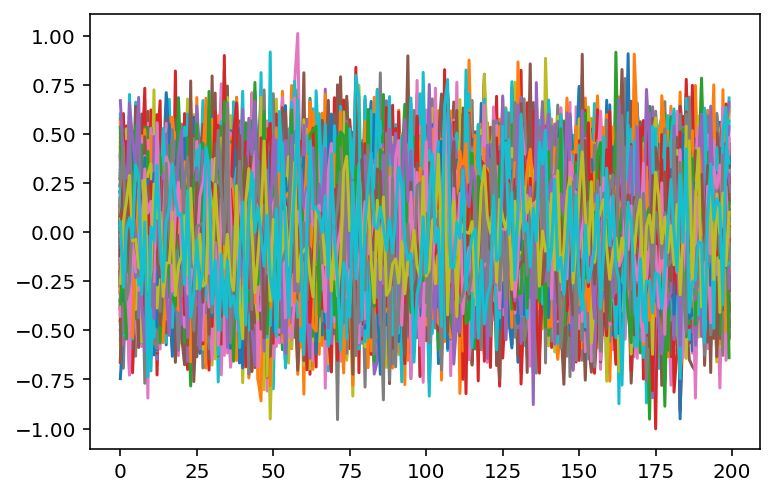

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

# 一行ずつ、500個のデータをプロットする
for i in range(500):
    plt.plot(embed_mat[i,:]);

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [36]:
# embed_mat の 上位500個を対象とする
viz_words  = 500    

# 次元削減用のインスタンスを作成
tsne       = TSNE() 

# 次元削減　：　(63641, 200) => (500, 2)
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

In [38]:
type(embed_tsne)

numpy.ndarray

In [39]:
embed_tsne.shape

(500, 2)

In [40]:
embed_tsne

array([[ 1.53742075e+00,  4.94507402e-02],
       [ 1.01007092e+00, -3.38666964e+00],
       [ 1.20209996e-02, -2.50495529e+00],
       [ 1.68172626e+01, -2.65472412e+01],
       [ 7.08413005e-01, -1.12476170e+00],
       [ 3.57488215e-01,  1.70351207e+00],
       [ 1.98827720e+00,  1.50776517e+00],
       [ 1.72979527e+01, -3.13203697e+01],
       [ 1.81532402e+01, -2.59287148e+01],
       [ 1.71250381e+01, -2.85732613e+01],
       [-1.04895031e+00,  2.59180307e+00],
       [-3.64772415e+00, -5.13003170e-01],
       [ 1.53412638e+01, -2.58504734e+01],
       [-2.13124275e-01, -1.38286967e-02],
       [ 6.70802021e+00, -1.76224279e+00],
       [ 1.83880463e+01, -2.99117546e+01],
       [ 1.90313568e+01, -2.80736485e+01],
       [ 1.18574848e+01, -2.94946384e+00],
       [ 2.67774129e+00, -7.50042379e-01],
       [ 2.04267025e+00,  5.74307203e+00],
       [ 2.00803394e+01, -3.01250305e+01],
       [ 1.57095041e+01, -2.99403267e+01],
       [ 1.49411469e+01, -2.79930096e+01],
       [ 3.

In [52]:
print( embed_tsne[0, :] )

# アスタリスク　は　中身を展開する
print( *embed_tsne[0, :] )
print("----------------------")
print(type(embed_tsne[0, :]))

[1.5374207  0.04945074]
1.5374207 0.04945074
----------------------
<class 'numpy.ndarray'>


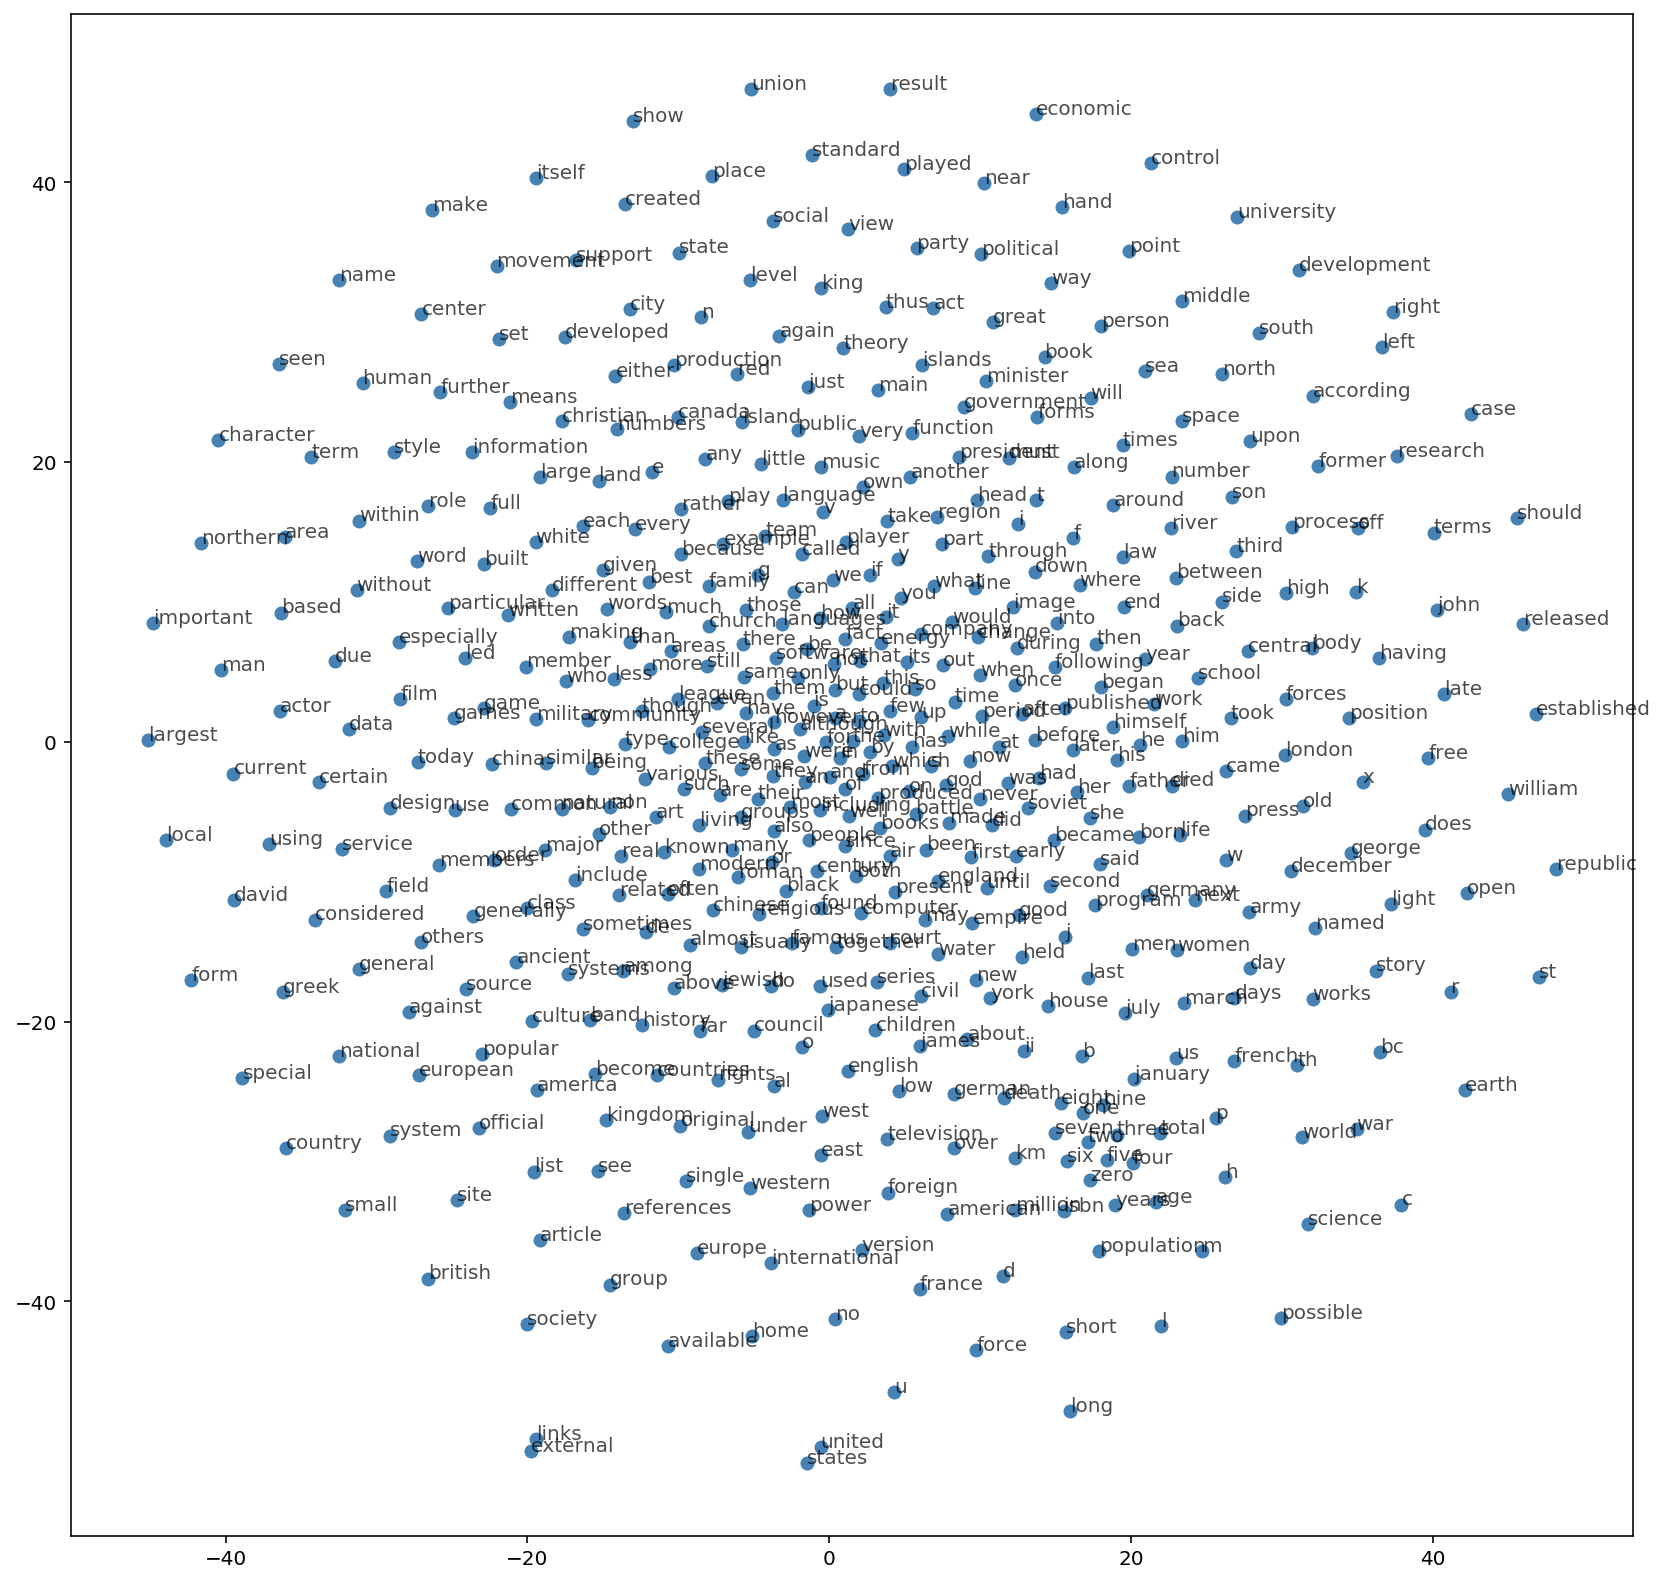

In [47]:
fig, ax = plt.subplots(figsize=(14, 14))

# 上位500個を一つずつプロットする
for idx in range(viz_words):
    # 丸のプロット　：　
   #plt.scatter(*embed_tsne[idx, :], color='steelblue') # アスタリスクでアンパックする方法
    plt.scatter(embed_tsne[idx, 0], embed_tsne[idx, 1], color='steelblue') # xとyを個別に書く方法
    
    # 単語の記述
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)